# 9.7 量子乱数発生器
古典コンピューターの場合は擬似乱数を発生させるが、量子コンピューターは純粋なランダムビットを取り出すことができる。
アイデアとしては、アダマールゲートを$|0\rangle$に作用させることで、
\begin{equation}
\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)
\end{equation}
を得て、その後Z基底で測定する、というもの。確率1/2ずつで0または1が得られる。

1キュービットに対する測定を10回行うコードを以下に示す。

In [1]:
"""Program for generating random bits in Cirq.
"""  
#Imports
import cirq 

In [2]:
#Helper function for visualizing output  
def bitstring(bits):
    return ''.join('1' if e else '0' for e in bits)  

#Get a qubit and quantum circuit
qbit = cirq.LineQubit(0)
circ = cirq.Circuit()

#Add the Hadamard and measure operations to the circuit  
circ.append([cirq.H(qbit), cirq.measure(qbit, key="z")]) #zは単に測定の名前づけと思われる。

#Simulate the circuit 
sim = cirq.Simulator() 
res = sim.run(circ, repetitions=10) 

#Print the outcome 
print("Bitstring =", bitstring(res.measurements["z"]))  #シミュレーション結果から、zと名付けた測定の結果を引っ張り出してくる。

Bitstring = 1101010010


10キュービットに対する測定を1回行うコードを以下に示す。

In [3]:
"""Program for generating random numbers in Cirq."""  
#Number of qubits  
n = 10

#Get a qubit and quantum circuit
qreg = [cirq.LineQubit(x) for x in range(n)]
circ = cirq.Circuit()

#Add the Hadamard and measure operations to the circuit 
for x in range(n): 
    circ.append([cirq.H(qreg[x]), cirq.measure(qreg[x])]) 
    
#Simulate the circuit  
sim = cirq.Simulator()  
res = sim.run(circ, repetitions=1) 
#Print the measured bitstring 
bits = bitstring(res.measurements.values()) 
print("Bitstring =", bits) 
#Print the integer corresponding to the bitstring つまり10進法で書くと
print("Integer =", int(bits, 2)) 


Bitstring = 0000010110
Integer = 22


# 9.8 量子ウォーク
量子ウォークでは、あるグラフ$G=(V,E)$上で粒子が動いている時、ある時間に頂点Vに粒子がいる確率やVまで到達する時間を考えることになる。
もしこれらの挙動が古典的ランダムウォークと異なっているなら、例えばグラフ問題にマップできる2-SAT充足問題について新しい解き方が見つかるかもしれない、というのが一つのモチベーション。

一番シンプルなランダムウォークは一次元上のランダムウォーク。その中でも非連続ウォークと連続ウォークがあり、非連続ウォークは各点から確率1/2で左か右のどちらかに移動していく、というもの。連続ウォークは粒子が各点にいる確率分布P(V)が変化していくというもの。

量子ウォークではポジション系$P$の他に、コイン系$C$を用いてある時点での状態が$|0\rangle_C \otimes |N\rangle_P$のように表される。あるコインの状態のもとで次の時点でのポジション状態へ遷移させるには、
\begin{equation}
S := |0\rangle \langle0|_C \otimes \sum_i |i-1 \rangle  \langle i|_P + |1\rangle \langle 1 |_C \otimes \sum_i | i+1 \rangle  \langle i|_P
\end{equation}
を作用させる。
量子ウォークにおいて半々の確率でコインを投げる操作は、半々で量子的重ね合わせを実現するアダマールゲート$H_C$を作用させることに対応する。
このとき、コインを投げてポジションを遷移させる１ステップの操作は
\begin{equation}
U = S(H_C \otimes I_P)
\end{equation}
と書ける。

この枠組み設定により、量子ウォークは古典ウォークとは異なる挙動を示すことがわかる。
例えば、状態が$|0\rangle_C \otimes |0\rangle_P$から始まる場合は分布は左に寄って行き、$|1\rangle_C \otimes |0\rangle_P$から始まる場合は分布は右に寄っていく。均等に広げて行きたい場合は$|+\rangle_C \otimes |0\rangle_P$から始める。他にも、$T$ステップ終わった後の分散が古典だと$T$に比例するのに対し、量子だと$T^2$に比例することが知られている。これは裏返せば二乗分だけ量子の方が速く伝搬するということ。

In [4]:
#4vertexの完全グラフ（vertex同士が全て結合しているグラフ）においてシミュレーションを行う。
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import expm
import pyquil.quil as pq
import pyquil.api as api
from pyquil.gates import H, X, CPHASE00 

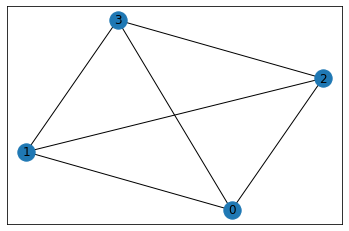

In [5]:
#Create a graph  
G = nx.complete_graph(4)
nx.draw_networkx(G) 

遷移行列をAとすると、完全グラフについては、Aの固有値は一つだけN-1で残りは全て-1になる（Nはノード数）

In [6]:
#Diagonalize the adjacency matrix 
A = nx.adjacency_matrix(G).toarray()
eigvals, eigvecs = np.linalg.eigh(A) 
#eigvecs = np.linalg.eig(A)
print("A=", A)
print("Eigenvalues =", eigvals) 
print("Eigenvectors =", eigvecs)

A= [[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]
Eigenvalues = [-1. -1. -1.  3.]
Eigenvectors = [[ 0.         -0.8660254  -0.         -0.5       ]
 [-0.29549093  0.28867513 -0.76115161 -0.5       ]
 [-0.51143117  0.28867513  0.63647846 -0.5       ]
 [ 0.8069221   0.28867513  0.12467315 -0.5       ]]


In [7]:
np.eye(4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

ハミルトニアンは、固有値０を増やして計算を簡単にするためH=A+Iとする。

In [8]:
ham = A + np.eye(4)

完全グラフの遷移行列はアダマールで対角化できることが既知だとすると、$Q = H \otimes H$、$\Lambda$を対角行列として、
\begin{equation}
H = Q \Lambda Q^{\dagger}
\end{equation}
これを以下で確認する。

In [9]:
#Hadamard gate  
hgate = np.sqrt(1/2) * np.array([[1, 1], [1, -1]])  
#Form the matrix Q = H \otimes H to diagonalize the Hamiltonian  
Q = np.kron(hgate, hgate)  
#Print out the Q^\dagger H Q to verify it’s diagonal  
diag = Q.conj().T.dot(ham).dot(Q) 
print(diag) 

[[ 4.00000000e+00 -4.93038066e-32 -4.93038066e-32  4.93038066e-32]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


右上の３つは実質０。H=A+Iとして0以外の固有値が一つだけになっているはずなので結果は整合している。
よって、時間発展オペレーターは以下のように書ける。
\begin{equation}
Q^{\dagger} e ^ {-iHt} Q = 
\left(
    \begin{array}{cccc}
      e ^ {-i4t} & 0 & 0 & 0 \\
      0 & 1 & 0 & 0 \\
      0 & 0 & 1 & 0 \\
      0 & 0 & 0 & 1
    \end{array}
  \right)
\end{equation}

これは二つのキュービットが両方$|0 \rangle$であった時にのみ位相が$\phi$だけシフトする$CZ_{00}(\phi)$（pyQuil内で定義されている）を用いて$CZ_{00}(-4t)$と表される。
これを用いて、以下に連続時間量子ウォークの時間発展のについてpyQuil量子プログラムを記述する。

In [10]:
#Function for a the continuous time quantum walk circuit on a  complete graph  
def k_4_ctqw(t): 
    """Returns a program implementing a continuous time quantum  walk."""  
    prog = pq.Program()  
    
    #Change to diagonal basis  
    prog.inst(H(0)) 
    prog.inst(H(1))  
    
    #Time evolve  
    prog.inst(CPHASE00(-4*t, 0, 1))  
    
    #Change back to computational basis  
    prog.inst(H(0)) 
    prog.inst(H(1)) 
    
    return prog

次に比較用に古典の連続ランダムウォークを考える。
離散ランダムウォークの場合は、あるtからt+1までの間に確率分布は

\begin{equation}
\vec{p}_{t+1} -  \vec{p}_t= 
\left(
    \begin{array}{cccc}
      -1 & 1/3 & 1/3 & 1/3 \\
      1/3 & -1 & 1/3 & 1/3 \\
      1/3 & 1/3 & -1 & 1/3 \\
      1/3 & 1/3 & 1/3 & -1
    \end{array}
  \right)
  \vec{p}_{t} c
\end{equation}
と書ける。ただしcは任意の定数。行列部分を$(M-I)$と置いて
\begin{equation}
\vec{p}_{t+1} -  \vec{p}_t= 
(M-I)
  \vec{p}_{t} c
\end{equation}
1ステップ間隔が微小とすると
\begin{equation}
\Delta \vec{p}_t = (M-I)\vec{p}_t c
\end{equation}
微分方程式
\begin{equation}
\frac{d\vec{p}_t}{dt} = (M-I)\vec{p}_t c
\end{equation}
を解いて
\begin{equation}
\vec{p}(t) = e^{(M-I)t}\vec{p}(0)
\end{equation}

In [11]:
M = A/ np.sum(A, axis = 0)
print(M)

[[0.         0.33333333 0.33333333 0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.33333333 0.33333333 0.33333333 0.        ]]


以下で計算用の時間発展の終わりとその刻み数を定める。

In [12]:
#Set up time to simulate for
tmax = 8
steps = 40
time = np.linspace(0, tmax, steps)  
#Arrays to hold quantum probabilities and classical probabilities  at each time  
quantum_probs = np.zeros((steps, 4))#tmaxから4に変えた。ここは2qbit状態の次元（つまり確率係数の数）がくるはずで、tmaxがくるのはおかしい。
classical_probs = np.zeros((steps, 4)) 

初期状態をノード0としてシミュレーションを行う。量子シミュレータの初期状態は|0\rangle |0\rangle（デフォルト設定）、古典シミュレータの場合はclassical_evの1列目を取る事が初期状態[1,0,0,0]の確率分布にclassical_evを作用させることに対応している。

In [13]:
from pyquil.api import QVMConnection
qvm = QVMConnection()

#Do the classical and quantum continuous-time walks  
for i, t in enumerate(time):  
    #Get a quantum program  
    prog = k_4_ctqw(t)
    #Simulate the circuit and store the probabilities  
    wvf = qvm.wavefunction(prog)
    vec = wvf.amplitudes
    quantum_probs[i] = np.abs(vec)**2
    #Do the classical continuous time walk  
    classical_ev = expm((M-np.eye(4))*t)
    classical_probs[i] = classical_ev[:, 0] 

以下に結果を図示する。

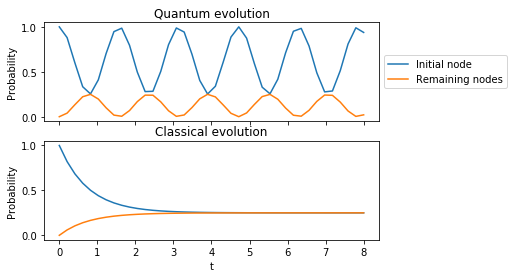

In [14]:
_, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)  
ax1.set_title("Quantum evolution")  
ax1.set_ylabel("Probability") 

ax1.plot(time, quantum_probs[:, 0], label='Initial node')  
ax1.plot(time, quantum_probs[:, 1], label='Remaining nodes')  
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
ax2.set_title("Classical evolution")  
ax2.set_xlabel('t')  
ax2.set_ylabel("Probability")  
ax2.plot(time, classical_probs[:, 0], label='Initial node')  
ax2.plot(time, classical_probs[:, 1], label='Remaining nodes') 

青が0ノード、黄がそれ以外のノードを表す。
量子は振動し、古典は0.25に収束する。